In [1]:
BUCKET_NAME = 'realtimeattendanceproject'
KEY_FILE = '/home/jupyter/realtimeattendanceproject@noble-cocoa-217110.iam.gserviceaccount.com.json'
SELECTOR_REGEX = r'^train/(\w+)/(\d+.png)$'
SEED = 20
DESIRED_SIZE = (100, 100)

In [2]:
from google.cloud import storage

import re
from functools import reduce

from pprint import pprint
import time

import numpy as np
import cv2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC

from matplotlib import pyplot as plt
%matplotlib inline

import pickle

In [3]:
client = storage.Client.from_service_account_json(KEY_FILE)
bucket = client.get_bucket(BUCKET_NAME)

In [4]:
def seive_train(blob):
    return re.match(SELECTOR_REGEX, blob.name) is not None

def get_md(blob): 
    re_obj = re.match(SELECTOR_REGEX, blob.name)
    return {
        'class_label': re_obj.group(1),
        'path': re_obj.group(0)
    }

img_res = filter(seive_train, bucket.list_blobs())

img_md = list(map(get_md, img_res))
pprint(img_md)

def reduction_step(prev, nex):
    if not nex['class_label'] in prev:
        prev.append(nex['class_label'])
    return prev

class_labels = reduce(reduction_step, img_md, [])
print(class_labels)

[{'class_label': 'akanksha', 'path': 'train/akanksha/0.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/1.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/10.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/11.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/12.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/13.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/14.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/15.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/16.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/17.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/18.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/19.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/2.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/20.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/21.png'},
 {'class_label': 'akanksha', 'path': 'train/akanksha/22.pn

In [5]:
def translate_class_labels(img_md):
    img_md['class_label'] = class_labels.index(img_md['class_label'])
    return img_md
img_md = list(map(translate_class_labels, img_md))

In [7]:
t0 = time.time()
ctr = 0.0 # OPTIONAL PART: PROGRESS BAR
def read_image(md):
    blob_bytes = bucket.get_blob(md['path']).download_as_string()
    blob_array = np.asarray(bytearray(blob_bytes), dtype = 'uint8')
    image = cv2.imdecode(blob_array, 0) # 0 for grayscale
    image_resized = cv2.resize(image, DESIRED_SIZE).flatten()
    
    global ctr # OPTIONAL PART: PROGRESS BAR
    ctr += 1 # OPTIONAL PART: PROGRESS BAR
    print('progress: %f' % (ctr / len(img_md)), end = '\r') # OPTIONAL PART: PROGRESS BAR
    
    return (image_resized, md['class_label'])

X, y = [
    list(t) for t in zip(
        *[read_image(md) for md in img_md]
    )
]
X, y = np.array(X, dtype = 'uint8'), np.array(y, dtype = 'uint8') 
print('Total: %0.3f seconds' % (time.time() - t0))

Total: 55.566 seconds


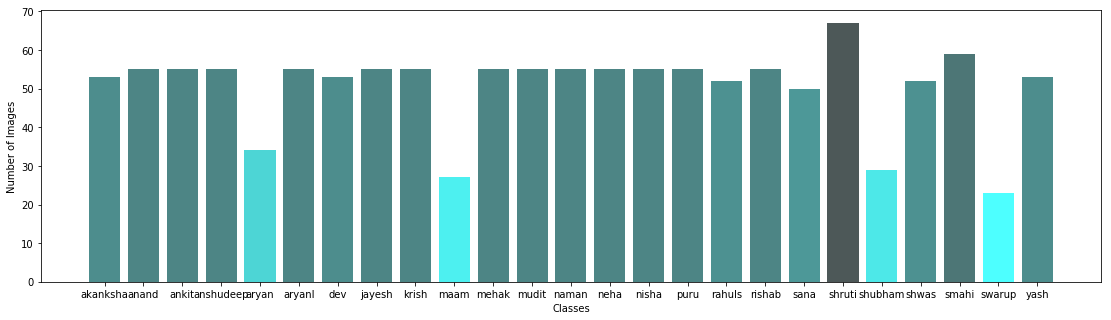

In [22]:
from collections import Counter
counts = Counter(y)

# determine colors (r, g, b) from heights
max_value, min_value = max(counts.values()), min(counts.values())
new_values = [
    ((value - min_value) / max_value)
    for value in counts.values()
]
# tuple of (r, g, b) (0.0-1.0 for each)
colors = [(0.3, 1 - value, 1 - value) for value in new_values]

plt.figure(figsize = (19, 5))
plt.bar(class_labels, counts.values(), color=colors)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

In [8]:
n_samples, h, w = X.shape[0], DESIRED_SIZE[0], DESIRED_SIZE[1]
n_features = X.shape[1]
n_classes = len(class_labels)
print("Dataset:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Dataset:
n_samples: 1267
n_features: 10000
n_classes: 25


In [10]:
TEST_SIZE = 0.3
# split into training testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [11]:
# this is the maximum possible PC
# may not yield good for large data set, LOOKUP!
N_PCA_COMPONENTS = int(min(n_samples, n_features) * (1 - TEST_SIZE)) # lookup how this is determined in svd_solver
N_PCA_COMPONENTS = 150

# DIMENSIONALITY REDUCTION USING PCA
print('Extracting top', N_PCA_COMPONENTS, 'eigen faces')
pca = PCA(n_components=N_PCA_COMPONENTS, svd_solver='randomized', whiten=True).fit(X_train)

Extracting top 150 eigen faces


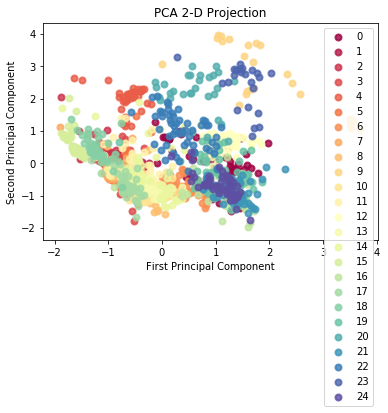

In [12]:
import scikitplot as skplt
skplt.decomposition.plot_pca_2d_projection(pca, X, y)

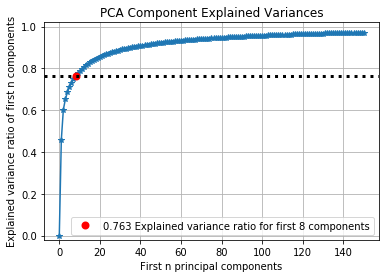

In [13]:
skplt.decomposition.plot_pca_component_variance(pca)

showing top 36 eigen faces


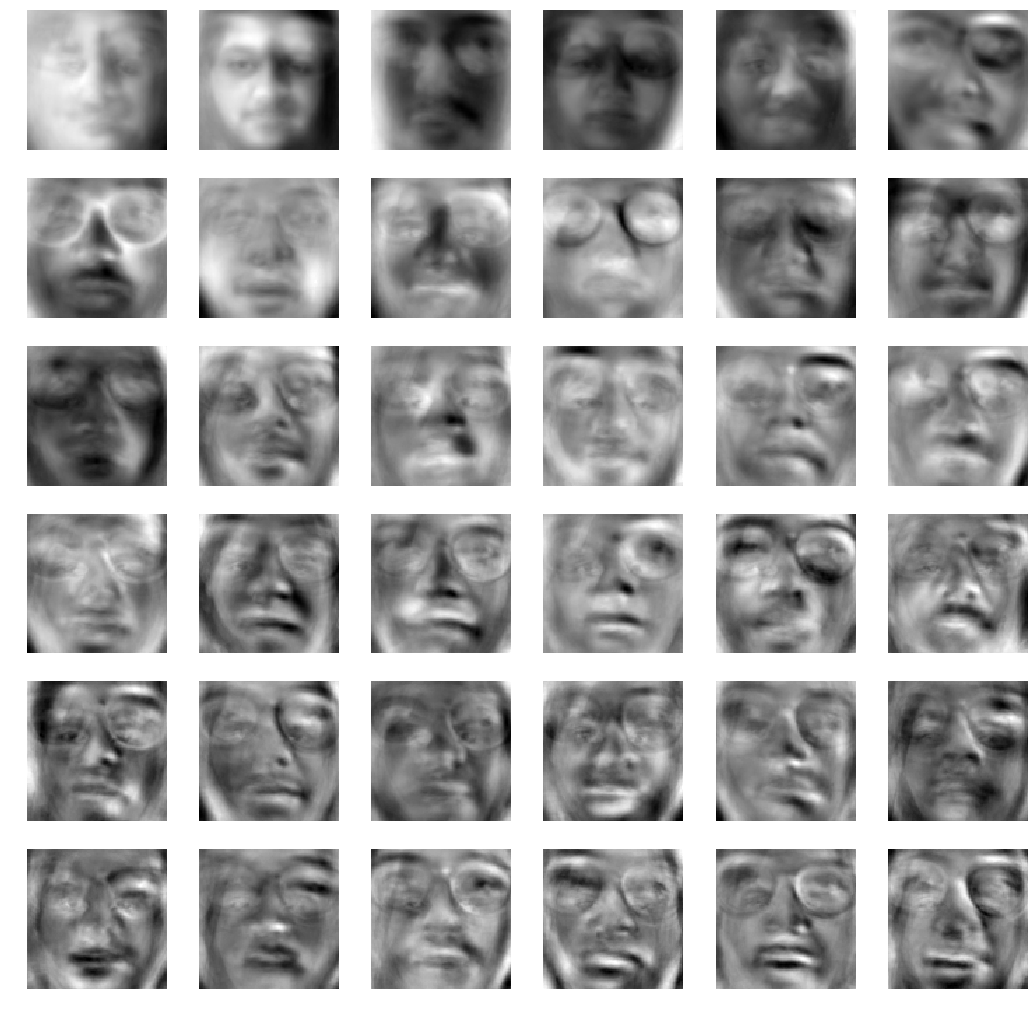

In [15]:
GRID = 6
eigenfaces = pca.components_.reshape((N_PCA_COMPONENTS, h, w))
print('showing top', GRID ** 2, 'eigen faces')
fig, axs = plt.subplots(GRID, GRID)
fig.set_figheight(18)
fig.set_figwidth(18)

ctr = 0
for eigenface in eigenfaces[0:GRID ** 2]:
    r_index = ctr // GRID
    c_index = ctr % GRID
    axs[r_index, c_index].axis('off')
    axs[r_index, c_index].imshow(eigenface, cmap = 'gray')
    ctr += 1
plt.show()

In [16]:
print('projecting the input data on the eigenfaces orthonormal basis')
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print('done')

projecting the input data on the eigenfaces orthonormal basis
done


In [17]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
# TRAIN A CLASSIFICATION MODEL USING AdaBoost and SVC
clf = AdaBoostClassifier(
    SVC(kernel='linear', max_iter=10000, C=1e3, probability=True)
)
clf.fit(X_train_pca, y_train)
print('Estimator is', clf)

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Estimator is AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=10000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          learning_rate=1.0, n_estimators=50, random_state=None)


prediction time! on test dataset
             precision    recall  f1-score   support

   akanksha       1.00      1.00      1.00        15
      anand       0.92      0.86      0.89        14
      ankit       1.00      0.94      0.97        18
  anshudeep       0.75      0.80      0.77        15
      aryan       1.00      1.00      1.00         7
     aryanl       0.91      1.00      0.95        21
        dev       0.95      1.00      0.97        19
     jayesh       0.94      0.94      0.94        17
      krish       1.00      1.00      1.00        18
       maam       1.00      1.00      1.00         7
      mehak       0.94      1.00      0.97        17
      mudit       0.89      0.94      0.91        17
      naman       1.00      1.00      1.00        14
       neha       0.92      0.86      0.89        14
      nisha       0.89      0.94      0.91        17
       puru       0.95      1.00      0.97        19
     rahuls       0.87      0.87      0.87        15
     rishab 

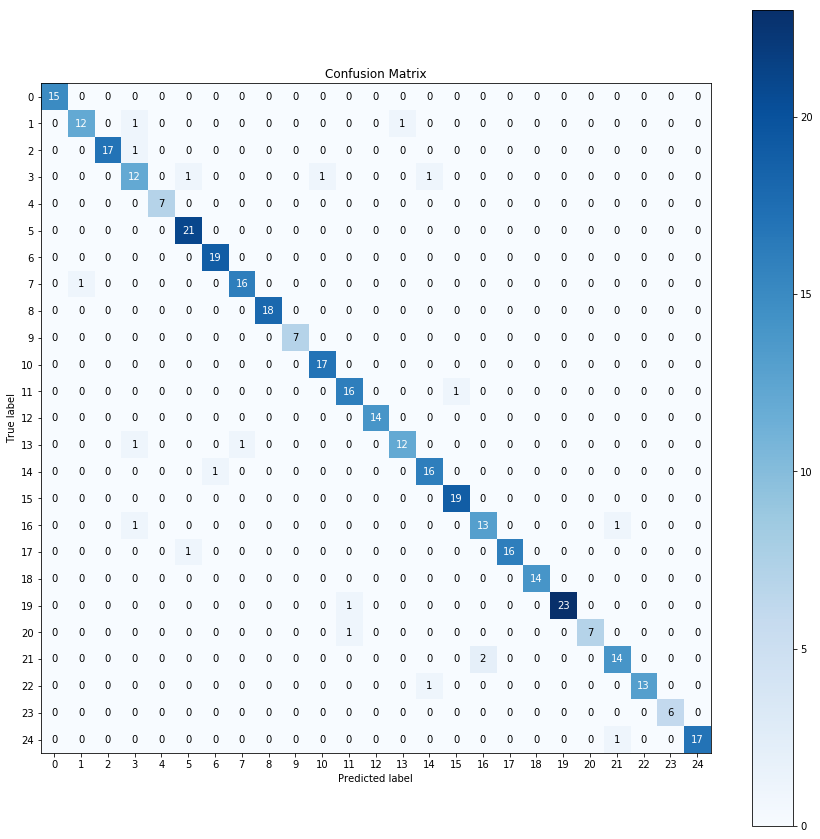

In [18]:
from scikitplot.metrics import plot_confusion_matrix
print('prediction time! on test dataset')
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=class_labels))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
plot_confusion_matrix(y_test, y_pred, labels=range(n_classes), figsize=(15, 15))

In [19]:
print('accuracy score on test data set')
clf.score(X_test_pca, y_test)

accuracy score on test data set


0.94750656167979

In [20]:
def save_as_pickle(file_name, obj):
    pickle_bytes = pickle.dumps(obj)
    blob = bucket.blob(file_name)
    blob.upload_from_string(pickle_bytes, 'application/octet-stream')
    print('saved to gs://%s/%s' % (BUCKET_NAME, file_name))

save_as_pickle('pca.pickle', pca)
save_as_pickle('class_labels.pickle', class_labels)
save_as_pickle('model.pickle', clf)

saved to gs://realtimeattendanceproject/pca.pickle
saved to gs://realtimeattendanceproject/class_labels.pickle
saved to gs://realtimeattendanceproject/model.pickle
